In [1]:
#Loaded by default (c.f.: ~/.ipython/profile_default/startup)
from __future__ import division, print_function
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ModuleNotFoundError: No module named 'pandas_summary'

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Clustering and K-Means

_Instructor: Amine Mehablia_

---

![](https://snag.gy/kYWumd.jpg)

### Learning Objectives
*After this lesson, you will be able to:*
- Understand basic unsupervised clustering problems
- Format and preprocess data for cluster
- Perform a K-Means Clustering Analysis
- Evaluate clusters for fit 



### Lesson Guide
- [Unsupervised learning](#unsupervised)
- [Introduction to clustering](#intro)
- [What is clustering?](#what)
- [KNN review](#knn)
- [Clustering algorithms](#algos)
- [K-means clustering](#k-means)
- [Refresher: Euclidean distance](#euclidean)
- [K-Means step-by-step](#km-steps)
- [K-Means: a visual example](#vis)
- [K-Means caveats and pitfalls](#caveats)
    - [Sensitive to outliers](#sensitive)
    - [Sensitive to centroid initialization](#centroid-init)
    - [How many K?](#how-many-k)
- [Choosing K](#choose-k)
- [A note on K-Means convergence](#converge)
- [K-Means in sklearn](#kmeans-skl)
    - [Visually verifying cluster labels](#verify)
- [Metrics: inertia and the silhouette coefficient](#sil)
- [Practice: use K-Means on the "Isotopic Composition Plutonium Batches" data](#pluto)
    - [How does scaling affect fit?](#scaling)
- [Conclusion: K-Means tradeoffs](#conclusion)
- [Additional resources](#resources)

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

<a id='unsupervised'></a>

## Unsupervised learning

---
 
> **Supervised --> Classification** - create a model to predict which group a point belongs to.  
> **Supervised --> Regression** - create a model to predict a metric.

> **Unsupervised --> Clustering** - find groups that exist in the data already.

Until now, we haven't talked much about unsupervised learning.  We use unsupervised methods when **we don't have labeled  data**. 
- There are no true targets to predict.

We derive the likely categories from the structure in our data.

| Pros | Cons |
|---|---|
| No labels | Difficult to evaluate correctness without subject matter expertise |
| Few or no assumptions about data | Scaling / normalization often required |
| Useful for subset / segmentation discovery | Can be difficult to visualize |
| Great for broad insights | Extremely difficult to tune |
| Many models avalable | No obvious choice in many cases |
| Black magic | Considered "unconventional" and unreliable |

<a name="intro"></a>
## Introduction to clustering

---

### Helpful uses for clustering: 
   - Find items with **similar behavior** (users, products, voters, etc)
   - Market **segmentation**
   - Understand complex systems
   - **Discover meaningful categories** for your data
   - **Reduce the number of classes** by grouping (e.g. bourbons, scotches -> whiskeys)
   - **Pre-processing**! Create labels for supervised learning

### Genetics
![](https://snag.gy/TP2RA4.jpg)

### Consumer Internet

<table>
    <tr>
        <td><img src="https://snag.gy/EbLeqd.jpg"></td>
        <td><img src="https://snag.gy/xsNvK8.jpg"></td>
    </tr>
</table>


### Business

<table>
    <tr>
    <td><img src="https://snag.gy/pDueQ2.jpg" width="500"></td>
    <td>
        <li>Identifying Demographics</li>
        <li>Spending Patterns</li>
        <li>Consumer Trends</li>
        <li>Customer Characteristics</li>
        <li>Recommender Systems</li>
        <li>Taxonomy / Categorization</li>
    </td>
    </tr>
</table>


## What do we mean by "labeled data"?
- Give me some examples!

<a id='what'></a>
## What is Clustering? 

---

<img src="https://snag.gy/BdfATE.jpg" style="width: 500px">

Clustering is one of the most ubiquitous and widespread processes for assigning **discrete structure to data**. In clustering, we group observations in a dataset together such that the members of a group are **more similar to each other** than they are to members of other groups. There are a **wide variety of methods** and criteria to perform this task.

**Properties of clustering procedures:**
- No **"true" target (`y`)** / response to compare
- We apply structure to data quantitatively based on **specific criteria**
- Predictions of label are based **on the structure of the data**

**For example:** your employer gives you a dataset of voter preferences from a local poll. They want you to figure out just exactly **how these voters are grouping based on their preferences**. The answer: clustering!

<a id='knn'></a>
## KNN review

---

KNN is a supervised classification method.

![](https://snag.gy/WPF4ZS.jpg)

**Questions (in pair):** 
- Discuss the plus/cons of unsupervised learning. In which situations would you use it? 
- Recall how the KNN algorithm works for classification. How would you modify it to turn it into an unsupervised algorithm?

<a name="algos"></a>
## Clustering algorithms 

---

The are [many different algorithms](http://scikit-learn.org/stable/modules/clustering.html) that can perform clustering given a dataset:

- **K-Means** (mean centroids)
- **Heirarchical** (nested clusters by merging or splitting successively)
- **DBSCAN** (density based)
- **Affinity Propagation** (graph based approach to let points 'vote' on their preferred 'exemplar')
- **Mean Shift** (can find number of clusters)
- **Spectral Clustering**
- **Agglomerative Clustering** (suite of algorithms all based on applying the same criteria/characteristics of one cluster to others)



Today we're going to look only at one of the algorithms: **k-means.**

<a id='k-means'></a>
## K-Means clustering

---

#### K-Means is the most popular clustering algorithm

K-means is one of the easier methods to understand and other clustering techniques use some of the same assumptions that K-Means relies on.

- **K** is the number of clusters.
- **Means** refers to the mean points of the K clusters.

The number of clusters $k$ is chosen in advance. The goal is to partition the data into set **such that the total sum of squared distances** from each point to the mean point of the cluster is minimized.

The algorithm takes your entire dataset and iterates over its features and observations to determine clusters based around center points. These center points are known as **centroids**. 

**Question:** What can you say about the loss function of the K-Means algorithm? What are the 2 most important consequences?

**K-means iterative fitting:**
1. Pick a value for k (the number of clusters to create)
2. Initialize k 'centroids' (starting points) in your data
3. Create your clusters. Assign each point to the nearest centroid. 
4. Make your clusters better. Move each centroid to the center of its cluster. 
5. Repeat steps 3-4 until your centroids converge. 

> **Note:** Unfortunately there is no formula to determine the absolute best number of $k$ clusters. Unsupervised learning is inherently subjective! We can, however, choose the "best" $k$ based on predetermined criteria. 

<a id='euclidean'></a>
## Refresher: Euclidean distance

---

### $$ d(x_1, x_2) = \sqrt{\sum_{i=1}^N (x_{1i} - x_{2i})^2} $$

**For example, take two points:**

- $x1 = (2, -1, 3)$
- $x2 = (-2, 2, 3)$

**The Euclidean distance between these two points is:**

### $$\begin{aligned}
d(x1, x2) &= \sqrt{ (2 - (-2))^2 + ((-1) - 2)^2 +(3 - 3)^2} \\
d(x1, x2) &= \sqrt{25} \\
d(x1, x2) &= 5 
\end{aligned}$$

**Using sklearn:**
```python
import numpy as np
from sklearn.metrics import euclidean_distances
X = np.array([[2, -1], [-2, 2]])
print(euclidean_distances(X))
```



<a id='km-steps'></a>
## K-Means step-by-step

---

<table width="500" cellpadding="50"> 
<tr>
   <td><img src="https://snag.gy/7haoS3.jpg" style="width: 150px"></td>
   <td style="vertical-align: top; width: 400px;"><br><b>Step 1.</b><br>We have data in a N-Dimensional feature space (2D for example).</td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td><img src="https://snag.gy/DaIVgk.jpg" style="width: 150px !important;"></td>
   <td style="align: top; width: 400px; vertical-align: top;"><br><b>Step 2.</b><br>Intialize K centroid (2 here).</td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td><img src="https://snag.gy/DaIVgk.jpg" style="width: 150px !important;"></td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Step 3.</b><br>Assign points to *closest* cluster based on _euclidean distance_.<br><br>$\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}$

   </td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td><img src="https://snag.gy/NY1EeT.jpg" style="width: 150px !important;"></td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Step 4.</b><br>Calculate mean of points assigned to centroid (2 here).  Update new centroid positions to mean (ie: geometric center).<br><br>$new\ centroid\ position= \bar{x}, \bar{y}$
   </td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td><img src="https://snag.gy/tSfDZs.jpg" style="width: 150px !important;"></td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Step 5.</b><br>Repeat step 3-4, updating class membership based on centroid distance.
   </td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td><img src="https://snag.gy/BbIicn.jpg" style="width: 150px !important;"></td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Fin.</b><br>Convergence is met once all points no longer change to a new class (defined by closest centroid distance).
   </td>
</tr>
<tr>
</table>

<a id='vis'></a>
## K-Means: a visual example

---

![](https://snag.gy/5hFXUA.jpg)

<a id='caveats'></a>
## A few K-Means caveats...

---

Nothing's perfect!

<a id='sensitive'></a>
### K-Means is sensitive to outliers

![](https://snag.gy/WFNMQY.jpg)

<a id='centroid-init'></a>
### K-Means is sensitive to centroid initialization

![](https://snag.gy/5sigCD.jpg)

<a id='how-many-k'></a>
### How many K?

Sometimes it's obvious, sometimes it's not!  What do you think?

<table>
    <tr>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="http://i.stack.imgur.com/4rU39.png"><br>1</td>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="http://i.stack.imgur.com/gq28F.png"><br>2</td>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="https://snag.gy/cWPgno.jpg"><br>3</td>
    </tr>
</table>

<a id='choose-k'></a>
## Choosing K

---

There are different methods of initializing centroids. For instance:

- Randomly
- Manually
- Special KMeans++ method in Sklearn (_This initializes the centroids to be generally distant from each other_)

**Depending on your problem, you may find some of these are better than others.**

> **Note:** Manual is recommended if you know your data well enough to see the clusters without much help, but rarely used in practice.

<a id='converge'></a>
## A note on K-Means convergence

---

In general, k-means will converge to a solution and return a partition of k clusters, even if no natural clusters exist in the data.  **It's entirely possible – in fact, *common* – that the clusters do not mean anything at all. **

**Knowing your domain and dataset is essential. Evaluating the clusters visually is a must (if possible).**

> _"Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='kmeans++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization, as shown in the reference."_ [sklearn Clustering Guide](http://scikit-learn.org/stable/modules/clustering.html#k-means)

![](http://www.datamilk.com/kmeans_animation.gif)

<img src="https://snag.gy/YUt5RO.jpg" style="float: left; margin-right: 25px; width: 250px">

## Pair questions:

- Explain on paper how the k-means algorithm works
- What problems do you think arise during "clustering"?
- What about the dimensions? Is it a problem for this algorithm? Explain with your own words
- What kind of data are we talking about? In the simple form of Kmeans, discuss its sensitivity to outliers.
- For two runs of K-Mean clustering is it expected to always get same clustering results?

<a id='kmeans-skl'></a>
## K-Means in sklearn

---

Below we will implement K-Means using sklearn.

In [58]:
%matplotlib inline

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
# we have only 2 dimntion here so n features is 2 
X, y = make_blobs(
    n_samples    =  200, 
    centers      =  3, 
    n_features   =  2,
    random_state =  0
)


df = pd.DataFrame(X, columns=['x', 'y'])
df.head()


,x,y
0,-1.733808,3.798061
1,0.628358,4.460136
2,1.131218,4.681950
3,-1.429179,3.500836
4,1.274508,5.630173


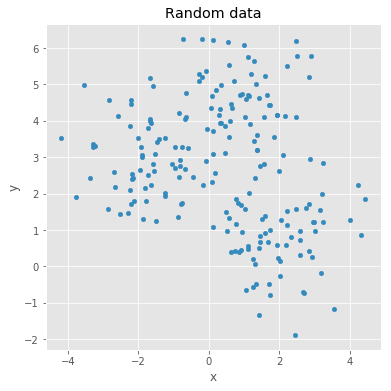

In [59]:
df.plot(kind="scatter", x="x", y="y", figsize=(6, 6), title="Random data");

In [60]:
## Take note that the latest version of Kmeans behaves a little differently now
model = KMeans(n_clusters=3, random_state=0).fit(df)

After we fit our data, we can get our predicted labels from `model.labels_` and the center points`model.cluster_centers_`.

In [61]:
predicted = model.labels_
centroids = model.cluster_centers_

print("Predicted clusters to points: ", predicted)
print("Location of centroids: ")
print(centroids)

Predicted clusters to points:  [1 0 0 1 0 1 2 0 0 1 0 1 0 0 0 1 2 2 1 1 1 2 0 0 1 1 2 1 1 1 0 0 1 0 2 2 0
 2 2 1 2 1 1 1 0 0 0 1 0 0 0 2 1 1 1 1 2 2 0 0 1 0 0 2 2 1 2 2 1 2 2 0 0 1
 0 1 2 2 2 1 1 0 0 2 2 0 0 1 0 2 1 1 2 0 2 0 0 1 1 2 2 0 1 0 1 0 2 0 1 2 0
 1 2 0 0 0 0 2 1 1 2 2 1 0 2 1 1 2 1 0 1 2 2 2 0 2 2 0 2 1 1 1 0 2 2 0 1 1
 2 0 2 1 1 1 0 2 2 2 0 0 2 1 1 1 0 0 2 1 2 2 1 2 0 2 1 1 2 1 0 2 0 1 2 2 2
 2 1 2 0 0 1 1 2 2 2 2 1 2 0 2]
Location of centroids: 
[[ 0.97692125  4.56883102]
 [-1.71656153  2.91261167]
 [ 1.98410174  0.81302038]]


In [62]:
df['predicted'] = predicted
df
df.head()

,x,y,predicted
0,-1.733808,3.798061,1
1,0.628358,4.460136,0
2,1.131218,4.681950,0
3,-1.429179,3.500836,1
4,1.274508,5.630173,0


<a id='verify'></a>
### Visually verifying cluster labels

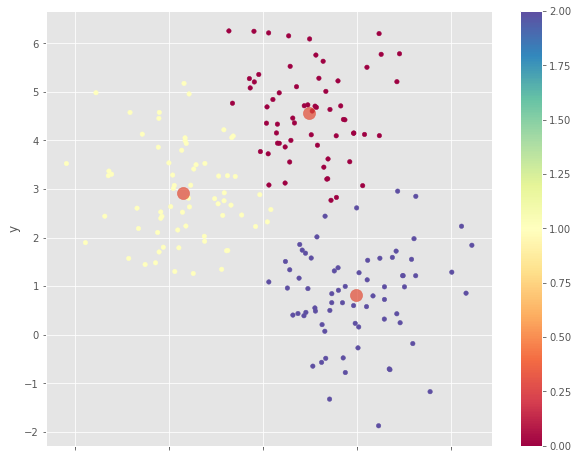

In [63]:
from matplotlib import pyplot as plt

df.plot(x="x", y="y", kind="scatter", c=df['predicted'], cmap='Spectral', figsize=(10,8));
plt.scatter(centroids[:,:1], centroids[:,1:], marker='o', s=150, alpha=0.7);


<a id='sil'></a>

## Metrics: inertia and the silhouette coefficient

---

**Inertia** -- sum of squared errors for each cluster
- low inertia = dense cluster
- ranges from 0 to very high values

$$\sum_{j=0}^{n} (x_j - \mu_i)^2$$
where $\mu_i$ is a cluster centroid. (K-means explicitly tries to minimize this.)

.inertia_ is an attribute of sklearn's kmeans models.

**Silhouette Coefficient** -- measure of how far apart clusters are
- high Silhouette Score = clusters are well separated
- ranges from -1 to 1

The definition is a little involved, but intuitively the score is based on **how much closer data points** are to their own clusters than to the nearest neighbor cluster.

We can calculate it in sklearn with metrics.silhouette_score(X_scaled, labels, metric='euclidean').
- https://en.wikipedia.org/wiki/Silhouette_(clustering)

In [14]:
score = silhouette_score(df, predicted, metric='euclidean')
score

0.5388481927664504

<a id='pluto'></a>
## Practice: sklearn + K-Means with "Isotopic Composition Plutonium Batches"

---

We have a nice [data dictionary](https://vincentarelbundock.github.io/Rdatasets/doc/cluster/pluton.html)

    Pu238 : the percentages of (238)Pu, always less than 2 percent.

    Pu239 : the percentages of (239)Pu, typically between 60 and 80 percent (from neutron capture of Uranium, (238)U).

    Pu240 : percentage of the plutonium 240 isotope.

    Pu241 : percentage of the plutonium 241 isotope.

In [15]:
csv_file = "https://vincentarelbundock.github.io/Rdatasets/csv/cluster/pluton.csv"
# there is also a copy of the csv in the assets/datasets file
df = pd.read_csv(csv_file, index_col=0)
df.head(5)

,Pu238,Pu239,Pu240,Pu241
1,0.126,75.804,21.204,2.180
2,0.133,75.515,21.408,2.240
3,0.127,75.175,21.668,2.305
4,0.156,78.872,18.428,1.906
5,0.503,73.317,20.223,4.128


###  Use Pu239 and Pu240 as our features.
1. Select only columns "Pu239" and "Pu240" to use for our example.
1. Plot it to see how it looks.
1. Initialize an instance of `KMeans` from `sklearn`.
1. Fit our sliced dataframe with the `fit`.

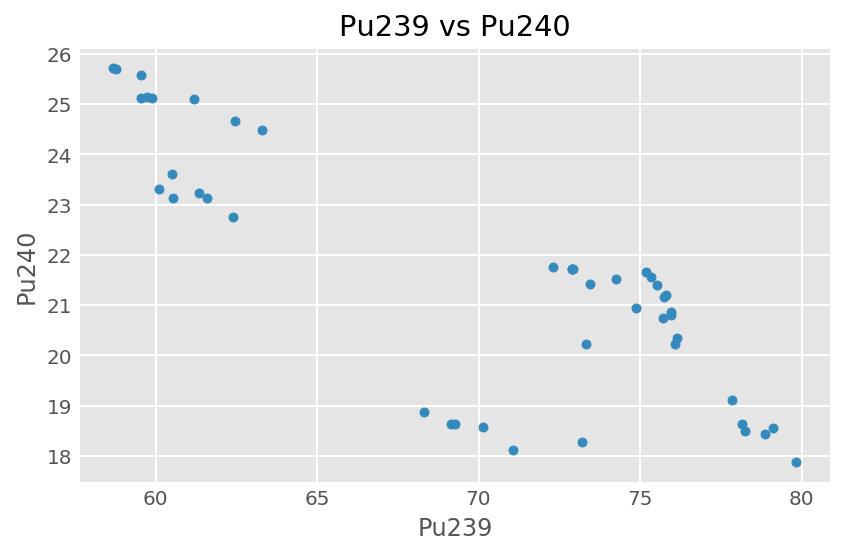

In [15]:
# Slice and check out our plot
features = ['Pu239', 'Pu240']
df[features].plot(kind="scatter", x=features[0], y=features[1], title="Pu239 vs Pu240");

In [ ]:
# 1. Run (instantiate and fit) K-Means against our 2 features 
# with 3 clusters
k = 3
model = 

# 2. Assign clusters back to our dataframe
df['cluster'] =

# 3. Get our centroids into a dataframe
centroids =
cc = pd.DataFrame(centroids)

# 4. Plot the scatter of our points with calculated centroids

# update x,y of our final clusters to plot later
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of our points with calculated centroids
ax.scatter(
# Centroids
ax.scatter(cc[0], cc[1], s=100)

# And our score
print("Silhouette Score: ", silhouette_score(
    df[features], df['cluster'], metric='euclidean'))

<a id='scaling'></a>
### Try standardizing the data first and see how it affects the cluster assignment


In [ ]:
# Repeat the same as above on scaled data.



<a id='conclusion'></a>
## Conclusion: K-Means tradeoffs

---

**K-Means:**
- Unsupervised clustering model
- Similar to KNN (but for “clustering”)
- Iteratively finds labels given K
- Easy to implement in sklearn
- Sensitive to shape, scale of data
- Optimal K hard to evaluate

---

| Strengths | Weaknesses |
| -- | -- |
| K-Means is popular because it's simple and computationally efficient. | However, K-Means is highly scale dependent and isn't suitable for data of varying shapes and densities. |
| Easy to see results / intuitive. | Evaluating results is more subjective, requiring much more human evaluation than trusted metrics. |

<a id='resources'></a>

## Additional resources

---

- Andrew Moore's CS class at Carnegie Mellon contains good static visualization, step-by-step. His slide deck is online here: http://www.cs.cmu.edu/~cga/ai-course/kmeans.pdf. He also links to more of his tutorials on the first page. 
- [Sci-Kit Learn Clustering Overview](http://scikit-learn.org/stable/modules/clustering.html#k-means)
- [SKLearn K-Means Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
- [SKLearn Clustering Code - See _k_init__ for explanation of k++ centroid selection](https://github.com/scikit-learn/scikit-learn/blob/51a765a/sklearn/cluster/k_means_.py#L769)
- [Clustering Tutorial](http://home.deib.polimi.it/matteucc/Clustering/tutorial_html/)
- [Wikipedia's Deep Dive on Clustering](https://en.wikipedia.org/wiki/K-means_clustering)


**Some helpful stackexchange questions:**
- http://stats.stackexchange.com/questions/40613/why-dont-dummy-variables-have-the-continuous-adjacent-category-problem-in-clust
- http://stats.stackexchange.com/questions/174556/k-means-clustering-with-dummy-variables
- http://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data


